In [49]:
import osmnx as ox
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import time

### Importing original mastra data

In [50]:
mastra_df = pd.read_csv('mastra.csv')

### Changing details and the data format - to a dictionary

In [51]:
# Verify the column names in the DataFrame
print(mastra_df.columns)


mastra_df = mastra_df.replace({'LÃ¸rdag': "Loerdag"}, regex=True)
mastra_df = mastra_df.replace({'SÃ¸ndag': "Soendag"}, regex=True)


mastra_df.rename(columns={'MÃ¥ned': 'Maened'}, inplace=True)
mastra_df.rename(columns={'Ãrstal': 'Aarstal'}, inplace=True)
mastra_df.rename(columns={'ï»¿Vej-Id': 'Vej-Id'}, inplace=True)

#mastra_df.drop(columns=['Unnamed: 1', 'Unnamed: 2'], inplace=True)

# Correct column names if necessary
columns_to_convert = [
    'Trafiktype',
    'Dagtype',
    'Vej-Id',
    'Retning',
    'Trafiktype'
]

# Convert the specified columns to float64
mastra_df = mastra_df.astype({col: 'string' for col in columns_to_convert})

mastra_df = mastra_df.replace({'<NA>': ""}, regex=True)

# Identify the columns that are not part of the time intervals
id_vars_columns = [
    'Vej-Id', 'Kilometer', 'Retning', 'Spor', 'Dato', 'Aarstal', 
    'Maened', 'Dag', 'Dagtype', 'Trafiktype', 'Xkoordinat', 'Ykoordinat'
]

# The time interval columns
time_columns = [
    "00:00-00:15","00:15-00:30","00:30-00:45","00:45-01:00","01:00-01:15","01:15-01:30","01:30-01:45","01:45-02:00","02:00-02:15","02:15-02:30","02:30-02:45","02:45-03:00","03:00-03:15","03:15-03:30","03:30-03:45","03:45-04:00","04:00-04:15","04:15-04:30","04:30-04:45","04:45-05:00","05:00-05:15","05:15-05:30","05:30-05:45","05:45-06:00","06:00-06:15","06:15-06:30","06:30-06:45","06:45-07:00","07:00-07:15","07:15-07:30","07:30-07:45","07:45-08:00","08:00-08:15","08:15-08:30","08:30-08:45","08:45-09:00","09:00-09:15","09:15-09:30","09:30-09:45","09:45-10:00","10:00-10:15","10:15-10:30","10:30-10:45","10:45-11:00","11:00-11:15","11:15-11:30","11:30-11:45","11:45-12:00","12:00-12:15","12:15-12:30","12:30-12:45","12:45-13:00","13:00-13:15","13:15-13:30","13:30-13:45","13:45-14:00","14:00-14:15","14:15-14:30","14:30-14:45","14:45-15:00","15:00-15:15","15:15-15:30","15:30-15:45","15:45-16:00","16:00-16:15","16:15-16:30","16:30-16:45","16:45-17:00","17:00-17:15","17:15-17:30","17:30-17:45","17:45-18:00","18:00-18:15","18:15-18:30","18:30-18:45","18:45-19:00","19:00-19:15","19:15-19:30","19:30-19:45","19:45-20:00","20:00-20:15","20:15-20:30","20:30-20:45","20:45-21:00","21:00-21:15","21:15-21:30","21:30-21:45","21:45-22:00","22:00-22:15","22:15-22:30","22:30-22:45","22:45-23:00","23:00-23:15","23:15-23:30","23:30-23:45","23:45-24:00"
]

# Melt the DataFrame to reshape it from wide format to long format
mastra_long = pd.melt(
    mastra_df,
    id_vars=id_vars_columns,  # Columns that uniquely identify each row
    value_vars=time_columns,  # Time interval columns
    var_name='time_interval',  # Name of the new column for the time intervals
    value_name='traffic_flow'  # Name for the traffic flow data
)

# Extract the start time from 'time_interval'
mastra_long['time_start'] = mastra_long['time_interval'].str[:5]  # Extracts the "00:00" part for sorting

mastra_long['datetime'] = pd.to_datetime(mastra_long['Dato'] + " " + mastra_long['time_start'], dayfirst=True)

mastra_long = mastra_long.sort_values(by=['Vej-Id', 'Dato', 'time_start'])
# Create a dictionary to store the DataFrames with unique key identifiers
grouped_dataframes = {}

# Group by the specified columns
for key, group in mastra_long.groupby(["Vej-Id", "Xkoordinat", "Ykoordinat"]):
    # Convert the 'datetime' column to Unix timestamps in seconds
    group['datetime'] = group['datetime'].apply(lambda x: int(time.mktime(x.timetuple())))

    # Use the unique key for naming or accessing each DataFrame
    sorted_group = group.sort_values(by=['Vej-Id', 'Dato', 'time_start'])
    grouped_dataframes[key] = sorted_group.reset_index(drop=True, inplace=False).set_index('datetime', inplace=False)


Index(['ï»¿Vej-Id', 'Unnamed: 1', 'Unnamed: 2', 'Kilometer', 'Retning', 'Spor',
       'Xkoordinat', 'Ykoordinat', 'Dato', 'Ãrstal',
       ...
       '21:30-21:45', '21:45-22:00', '22:00-22:15', '22:15-22:30',
       '22:30-22:45', '22:45-23:00', '23:00-23:15', '23:15-23:30',
       '23:30-23:45', '23:45-24:00'],
      dtype='object', length=110)


### Columns to keep 

In [52]:
columns_to_keep = ['Vej-Id', 'Dato', 'Xkoordinat', 'Ykoordinat', 'traffic_flow', 'time_start']

for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][columns_to_keep]

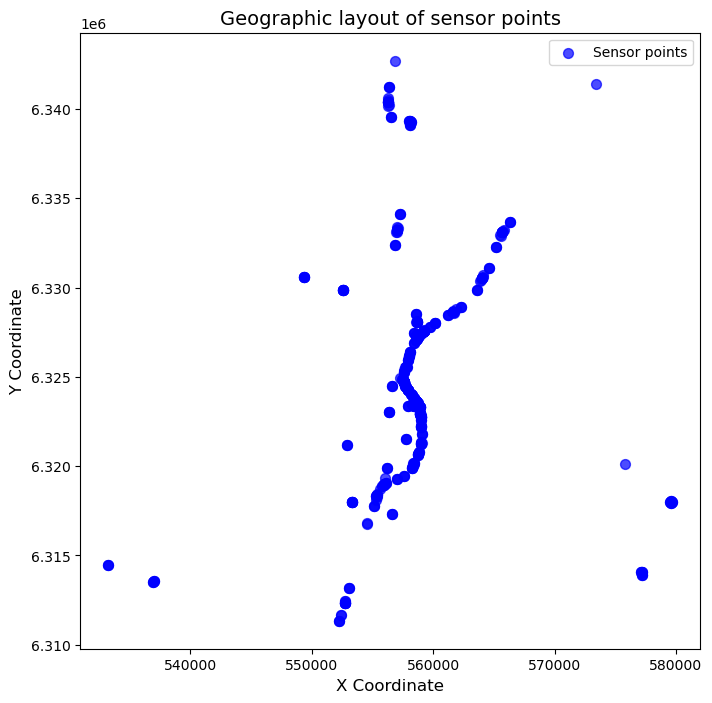

In [53]:
graph = nx.Graph()

for i, (key, df) in enumerate(grouped_dataframes.items()):  # Use enumerate for unique integer keys
    x = df['Xkoordinat'].iloc[0]
    y = df['Ykoordinat'].iloc[0]
    #traffic_flow = np.array(df['traffic_flow'])  # Convert to NumPy array
    #time_step = np.array(df['time_step'])  # Convert to NumPy array
    graph.add_node(i, x=x, y=y)

# Extract positions from the graph's node attributes
pos = {node: (data['x'], data['y']) for node, data in graph.nodes(data=True)}

# Extract x and y coordinates for nodes
x_values = [coord[0] for coord in pos.values()]
y_values = [coord[1] for coord in pos.values()]

# Plot the distance graph
plt.figure(figsize=(8, 8))
plt.title("Geographic layout of sensor points", fontsize=14)

#plt.grid(True, linestyle='--', alpha=0.5)
plt.scatter(x_values, y_values, c='blue', s=50, label='Sensor points', alpha=0.7)


for edge in graph.edges():
    x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
    y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
    plt.plot(x_coords, y_coords, color='gray', alpha=0.7)

# Set axis labels
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)


# Show legend
plt.legend()
# Display the plot
plt.show()

### Only keep dataframes with total traffic flow (T in Vej-Id)

In [54]:
names = list(grouped_dataframes.keys())
filtered_dataframes = {}
for name in names:
    single_name = name[0]
    if single_name[-1] in ["T"]:
        filtered_dataframes[name] = grouped_dataframes[name]
grouped_dataframes = filtered_dataframes

### Fixing thousand separation 

In [55]:
def adjust_traffic_flow(df, column_name, multiplier=50):
    """
    Adjusts the traffic flow value of 1.0 in a DataFrame to 1000 if it is between
    two values that are significantly higher (default: multiple of 2).

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the traffic flow column.
        multiplier (float): The factor that determines "significantly higher".

    Returns:
        pd.DataFrame: Modified DataFrame with adjusted traffic flow values.
    """

    df[column_name] = df[column_name].apply(lambda x: x * 10**3 if not pd.isna(x) and x != int(x) else x)

    traffic_flow = df[column_name].values
    for i in range(1, len(traffic_flow) - 1):
        # Check if the current value is 1.0 and it's between two values that are higher
        if (traffic_flow[i] == 1.0 and 
            traffic_flow[i - 1] > multiplier and 
            traffic_flow[i + 1] > multiplier):
            traffic_flow[i] = 1000
    
    # Update the DataFrame column
    df[column_name] = traffic_flow
    return df

grouped_dataframes = {key: adjust_traffic_flow(df, 'traffic_flow') for key, df in grouped_dataframes.items()}

### Creating an empty dataframe matching 'mastra' biggest possible shape
Combining the empty dataframe with every dataframe in the dictionary

In [56]:
# Define the date range
date_range = pd.date_range(start='2023-01-01', end='2024-08-31', freq='D')

# Define the time range with 15-minute intervals
time_range = pd.date_range(start='00:00', end='23:45', freq='15min').time

# Create a MultiIndex with all combinations of dates and times
multi_index = pd.MultiIndex.from_product([date_range, time_range], names=['Dato', 'time_start'])

# Create the DataFrame
empty_df = pd.DataFrame(index=multi_index, columns=['Vej-Id', 'Xkoordinat', 'Ykoordinat', 'traffic_flow'])

# Reset the index to have 'datetime' as a column
empty_df = empty_df.reset_index()

# Format 'Dato' as mm.dd.yyyy
empty_df['Dato'] = empty_df['Dato'].dt.strftime('%d.%m.%Y')

# Combine 'Dato' and 'time_start' into a single datetime column (ensure correct formatting)
empty_df['datetime'] = pd.to_datetime(empty_df['Dato'] + ' ' + empty_df['time_start'].astype(str), format='%d.%m.%Y %H:%M:%S')

# Convert datetime to UNIX timestamp
empty_df['datetime'] = empty_df['datetime'].apply(lambda dt: int(time.mktime(dt.timetuple())))

# Set 'datetime' as the index
empty_df = empty_df.set_index('datetime')

# Ensure 'time_start' contains only hour and minutes as strings
empty_df['time_start'] = empty_df.index.map(lambda ts: pd.to_datetime(ts, unit='s').strftime('%H:%M'))

# Fill other columns with placeholder data
empty_df['Vej-Id'] = np.nan  # Placeholder for Vej-Id
empty_df['Dato'] = empty_df.index.map(lambda ts: pd.to_datetime(ts, unit='s').strftime('%d.%m.%Y'))  # Re-format Dato column

# Set NaN for other columns
empty_df['Xkoordinat'] = np.nan          # Set NaN for Xkoordinat
empty_df['Ykoordinat'] = np.nan          # Set NaN for Ykoordinat
empty_df['traffic_flow'] = np.nan        # Set NaN for traffic_flow

# Reorder columns
empty_df = empty_df[['Vej-Id', 'Dato', 'Xkoordinat', 'Ykoordinat', 'traffic_flow', 'time_start']]

# Remove the first 4 rows and adjust index
empty_df = empty_df.iloc[4:]
empty_df.index = empty_df.index - 3600  # Subtract 3600 seconds (1 hour) from each index value

# Define the additional time range for 31.08.2024
additional_time_range = pd.date_range(start='2024-08-31 22:00', end='2024-08-31 23:45', freq='15min')

# Create a DataFrame for the new rows
additional_df = pd.DataFrame({
    'datetime': additional_time_range.map(lambda dt: int(time.mktime(dt.timetuple()))),  # Convert to UNIX timestamp
    'Vej-Id': np.nan,
    'Dato': additional_time_range.strftime('%d.%m.%Y'),
    'Xkoordinat': np.nan,
    'Ykoordinat': np.nan,
    'traffic_flow': np.nan,
    'time_start': additional_time_range.strftime('%H:%M'),
})

# Set 'datetime' as the index
additional_df = additional_df.set_index('datetime')

# Append the new rows to the original DataFrame
empty_df = pd.concat([empty_df, additional_df])

# Display the last few rows to verify
empty_df.shape

for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][~grouped_dataframes[key].index.duplicated(keep='first')]

for key in grouped_dataframes.keys():
    grouped_dataframes[key] = empty_df.combine_first(grouped_dataframes[key])

for key in grouped_dataframes.keys():
    grouped_dataframes[key] = grouped_dataframes[key][~grouped_dataframes[key].index.duplicated(keep='first')]

In [57]:
for key in grouped_dataframes.keys():
    grouped_dataframes[key]['Vej-Id'] = grouped_dataframes[key]['Vej-Id'].ffill().bfill()
    grouped_dataframes[key]['Xkoordinat'] = grouped_dataframes[key]['Xkoordinat'].ffill().bfill()
    grouped_dataframes[key]['Ykoordinat'] = grouped_dataframes[key]['Ykoordinat'].ffill().bfill()

### Combining dataframes by aggregating traffic flow, if X and Y coordinates match
one instance, but still

In [58]:
# Create a new dictionary to store the aggregated dataframes
aggregated_dataframes = {}

# Iterate over the grouped dataframes
for key, df in grouped_dataframes.items():
    # Create a unique key based on Xkoordinat and Ykoordinat
    coord_key = (df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0])
    
    if coord_key not in aggregated_dataframes:
        # Initialize the dataframe in the aggregated dictionary
        aggregated_dataframes[coord_key] = df.copy()
    else:
        # Aggregate traffic_flow by summing up the values, ignoring NaNs
        aggregated_dataframes[coord_key]['traffic_flow'] += df['traffic_flow'].fillna(0)
        
        # Keep the shortest Vej-Id
        aggregated_dataframes[coord_key]['Vej-Id'] = aggregated_dataframes[coord_key]['Vej-Id'].combine(
            df['Vej-Id'], lambda x, y: x if len(x) < len(y) else y
        )

filtered_dataframes = aggregated_dataframes

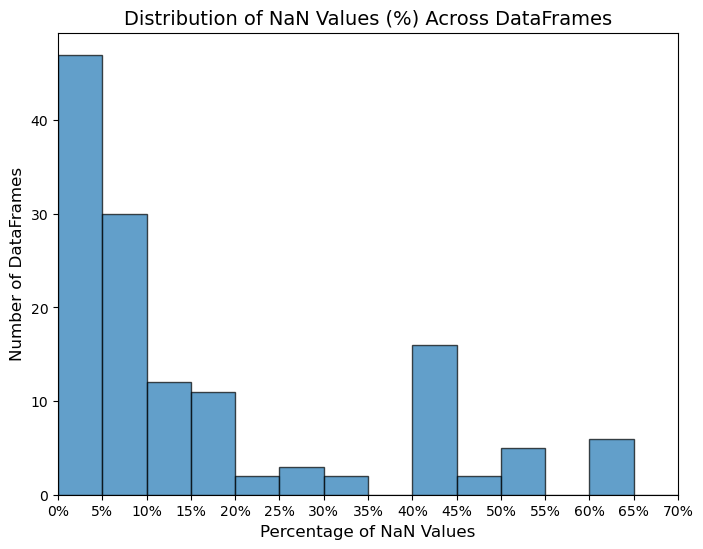

In [59]:
nan_percentage = {}

for key, df in filtered_dataframes.items():
    nan_count = df['traffic_flow'].isna().sum()
    total_count = len(df)
    nan_percentage[key] = (nan_count / total_count) * 100

nan_values_list = list(nan_percentage.values())

bin_edges = np.arange(0, 75, 5) 
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2 

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(nan_values_list, bins=bin_edges, edgecolor='black', alpha=0.7)
plt.title('Distribution of NaN Values (%) Across DataFrames', fontsize=14)
plt.xlabel('Percentage of NaN Values', fontsize=12)
plt.ylabel('Number of DataFrames', fontsize=12)
plt.xticks(bin_edges, labels=[f"{int(edge)}%" for edge in bin_edges])
plt.xlim(bin_edges[0], bin_edges[-1])
plt.show()

### Two functions to find longest non nan period 
(with option to add acceptable amount of nan values)

In [60]:
def find_and_apply_longest_period(filtered_dataframes, threshold=5):
    """
    Loops over all dataframes in filtered_dataframes, finds the longest period 
    without exceeding the threshold of consecutive NaN values, and filters 
    the dataframe to include only that period.

    Parameters:
    - filtered_dataframes (dict): A dictionary of dataframes to process.
    - threshold (int): Maximum allowed consecutive NaN values.

    Returns:
    - dict: Updated filtered_dataframes with filtered dataframes.
    """
    def find_longest_valid_period(series, threshold):
        """
        Finds the longest valid period in the series, allowing up to `threshold` NaN values consecutively.
        """
        mask = series.notna()
        count = 0
        start = end = 0
        max_start = max_end = 0
        nans = 0

        for i in range(len(mask)):
            if mask.iloc[i]:
                count += 1
                nans = 0
            else:
                nans += 1
                if nans > threshold:
                    count = 0
                    nans = 0
                    start = i + 1
            if count > (max_end - max_start):
                max_start, max_end = start, i + 1
        return max_start, max_end

    for name, df in filtered_dataframes.items():
        # Assuming the column to check for NaN values is named 'Value'
        if 'traffic_flow' in df.columns:
            start_idx, end_idx = find_longest_valid_period(df['traffic_flow'], threshold)
            filtered_dataframes[name] = df.iloc[start_idx:end_idx]

    return filtered_dataframes

filtered_dataframes_period = find_and_apply_longest_period(filtered_dataframes.copy(), threshold=5)

### Handeling missing values with interpolation

In [61]:
for name, df in filtered_dataframes_period.items():
    # Interpolate NaN values in all columns with numeric data
    filtered_dataframes_period[name]['traffic_flow'] = df['traffic_flow'].interpolate(method='linear', limit_direction='both')

/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_1847/3238806851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataframes_period[name]['traffic_flow'] = df['traffic_flow'].interpolate(method='linear', limit_direction='both')


In [62]:
# longest consecutive streak of NA in filtered_dataframes_period[name]['traffic_flow']
#for name in filtered_dataframes_period:
    #print(name, filtered_dataframes_period[name]['traffic_flow'].isna().astype(int).groupby(filtered_dataframes_period[name]['traffic_flow'].notna().astype(int).cumsum()).cumsum().max(), len(filtered_dataframes_period[name]['traffic_flow']))

### Removing highest starting and lowest ending indicies, to increase shared index range

In [63]:
def remove_extreme_dataframes(one_week_dfs, n, m):
    # Sort dataframes by their starting index value
    sorted_by_start = sorted(one_week_dfs.items(), key=lambda item: item[1].index[0])
    
    # Sort dataframes by their ending index value
    sorted_by_end = sorted(one_week_dfs.items(), key=lambda item: item[1].index[-1])
    
    # Remove n dataframes with the highest starting index value
    to_remove_start = sorted_by_start[-n:]
    
    # Remove m dataframes with the lowest ending index value
    to_remove_end = sorted_by_end[:m]
    
    # Create a set of keys to remove
    keys_to_remove = set(key for key, _ in to_remove_start + to_remove_end)
    
    # Remove the dataframes from one_week_dfs
    one_week_dfs = {key: df for key, df in one_week_dfs.items() if key not in keys_to_remove}
    
    return one_week_dfs

highest_duration = 0
count_removing = 200

for n in range(0, 80):
    for m in range(0, 80):
        temp_one_week_dfs = remove_extreme_dataframes(filtered_dataframes_period, n, m)
        
        if temp_one_week_dfs:  # Check if temp_one_week_dfs is not empty
            highest_starting_index = max(df.index[0] for df in temp_one_week_dfs.values())
            lowest_ending_index = min(df.index[-1] for df in temp_one_week_dfs.values())
            duration_days = ((lowest_ending_index - highest_starting_index) / 3600) / 24
            if duration_days >= 0 and duration_days > highest_duration:
                print(f"n = {n}, m = {m}")
                print("Number of dataframes after removal:", len(temp_one_week_dfs))
                print("Highest starting index value:", highest_starting_index)
                print("Lowest ending index value:", lowest_ending_index)
                print("Duration in days:", duration_days)
                if duration_days > highest_duration and count_removing > n+m:	
                    highest_duration = duration_days
                    count_removing = n + m
                    best_start = highest_starting_index
                    best_end = lowest_ending_index
                    best_n = n
                    best_m = m


print("Best start:", best_start)
print("Best end:", best_end)
print("Best n:", best_n)
print("Best m:", best_m)
print("Highest duration in days:", highest_duration)


n = 17, m = 67
Number of dataframes after removal: 52
Highest starting index value: 1703285100
Lowest ending index value: 1703484000
Duration in days: 2.3020833333333335
n = 17, m = 70
Number of dataframes after removal: 49
Highest starting index value: 1703285100
Lowest ending index value: 1703530800
Duration in days: 2.84375
n = 17, m = 71
Number of dataframes after removal: 48
Highest starting index value: 1703285100
Lowest ending index value: 1703530800
Duration in days: 2.84375
n = 17, m = 72
Number of dataframes after removal: 47
Highest starting index value: 1703285100
Lowest ending index value: 1703530800
Duration in days: 2.84375
n = 17, m = 73
Number of dataframes after removal: 46
Highest starting index value: 1703285100
Lowest ending index value: 1703530800
Duration in days: 2.84375
n = 17, m = 74
Number of dataframes after removal: 45
Highest starting index value: 1703285100
Lowest ending index value: 1703530800
Duration in days: 2.84375
n = 17, m = 75
Number of dataframes

### Dataframes to remove

In [64]:
n = 79  # Number of dataframes to remove with the highest starting index value
m = 54  # Number of dataframes to remove with the lowest ending index value
filtered_dataframes_reduced = remove_extreme_dataframes(filtered_dataframes_period, n, m)
print(len(filtered_dataframes_reduced))

32


### Defining the index range

In [65]:
start = 1672527600# - 3588300
end = 1703530800

final_dataframes = {}

for name, df in filtered_dataframes_reduced.items():
    # Ensure the index is unique and monotonic
    if not df.index.is_unique:
        print(f"Duplicate indices found in {name}. Dropping duplicates.")
        # print ducplicates
        df = df[~df.index.duplicated(keep='first')]

    if not df.index.is_monotonic_increasing:
        print(f"Index of {name} is not sorted. Sorting the index.")
        df = df.sort_index()

    if start in df.index and end in df.index:
        final_dataframes[name] = df.loc[start:end]
    # elif start > df.index[0] and end < df.index[-1]:
    #     try:
    #         final_dataframes[name] = df.loc[start:end]
    #     except KeyError:
    #         print("Trying something else")
    #         # Find the nearest index to start and end
    #         start_index = df.index.get_indexer([start], method='nearest')[0]
    #         end_index = df.index.get_indexer([end], method='nearest')[0]
    #         final_dataframes[name] = df.iloc[start_index:end_index+1]
    else:
        print(f"Data range does not fit for {name}. Skipping. Start: {start-df.index[0]}, End: {df.index[-1]-end}")
print("Final Dataframes", len(final_dataframes))

Final Dataframes 32


### Better safe than sorry

In [66]:
# Gather all start and end index values for analysis
start_values = []
end_values = []

for name, df in final_dataframes.items():
    start_values.append(df.index[0])
    end_values.append(df.index[-1])

start_values = pd.Series(start_values)
end_values = pd.Series(end_values)

# Determine the most common start and end indices
common_start = start_values.value_counts().idxmax()
common_end = end_values.value_counts().idxmax()

# Apply the common range to all DataFrames
updated_final_dataframes = {}
for name, df in final_dataframes.items():
    # Check if the common_start and common_end exist in the DataFrame
    if common_start in df.index and common_end in df.index:
        updated_final_dataframes[name] = df.loc[common_start:common_end].copy()
    else:
        print(f"Skipping {name} - range {common_start} to {common_end} not found. Dataframe start: {df.index[0]}, end: {df.index[-1]} Diff start: {common_start - df.index[0]}, end: {df.index[-1] - common_end}")

# Replace the final_dataframes with updated ones
final_dataframes = updated_final_dataframes

# Verify results
print(f"Updated DataFrames: {len(final_dataframes)}")
for name, df in final_dataframes.items():
    print(f"{name}: Start {df.index[0]}, End {df.index[-1]}, Length {len(df)}")


Updated DataFrames: 32
(549360.0, 6330576.0): Start 1672527600, End 1703530800, Length 34449
(555132.0, 6317792.0): Start 1672527600, End 1703530800, Length 34449
(555308.0, 6318304.0): Start 1672527600, End 1703530800, Length 34449
(555292.0, 6318128.0): Start 1672527600, End 1703530800, Length 34449
(555588.0, 6318742.0): Start 1672527600, End 1703530800, Length 34449
(558928.0, 6322894.0): Start 1672527600, End 1703530800, Length 34449
(558981.0, 6322888.0): Start 1672527600, End 1703530800, Length 34449
(555341.0, 6318418.0): Start 1672527600, End 1703530800, Length 34449
(557255.0, 6324952.0): Start 1672527600, End 1703530800, Length 34449
(557437.0, 6324871.0): Start 1672527600, End 1703530800, Length 34449
(557426.0, 6324854.0): Start 1672527600, End 1703530800, Length 34449
(558870.0, 6327287.0): Start 1672527600, End 1703530800, Length 34449
(563949.0, 6330413.0): Start 1672527600, End 1703530800, Length 34449
(564139.0, 6330707.0): Start 1672527600, End 1703530800, Length 344

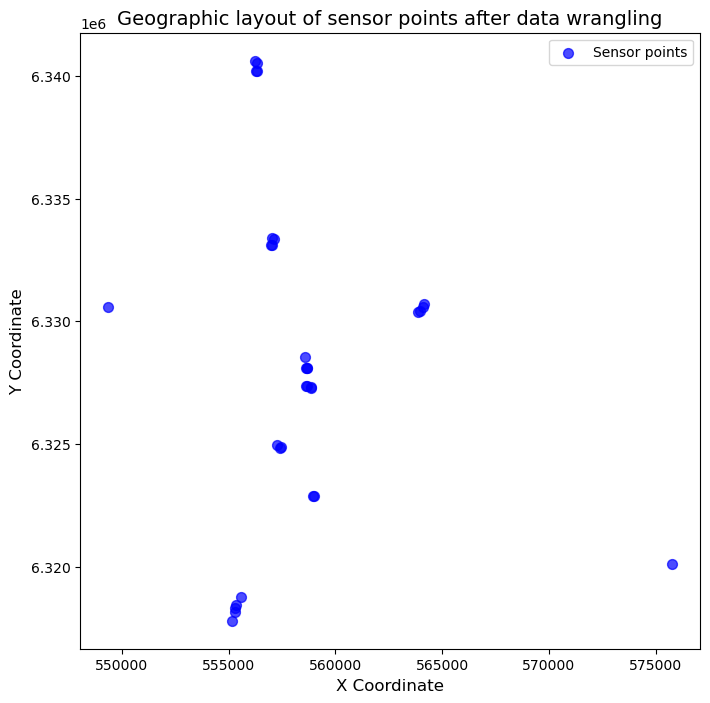

In [71]:
graph = nx.Graph()

for i, (key, df) in enumerate(final_dataframes.items()):  # Use enumerate for unique integer keys
    x = df['Xkoordinat'].iloc[0]
    y = df['Ykoordinat'].iloc[0]
    #traffic_flow = np.array(df['traffic_flow'])  # Convert to NumPy array
    #time_step = np.array(df['time_step'])  # Convert to NumPy array
    graph.add_node(i, x=x, y=y)

# Extract positions from the graph's node attributes
pos = {node: (data['x'], data['y']) for node, data in graph.nodes(data=True)}

# Extract x and y coordinates for nodes
x_values = [coord[0] for coord in pos.values()]
y_values = [coord[1] for coord in pos.values()]

# Plot the distance graph
plt.figure(figsize=(8, 8))
plt.title("Geographic layout of sensor points after data wrangling", fontsize=14)

#plt.grid(True, linestyle='--', alpha=0.5)
plt.scatter(x_values, y_values, c='blue', s=50, label='Sensor points', alpha=0.7)


for edge in graph.edges():
    x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
    y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
    plt.plot(x_coords, y_coords, color='gray', alpha=0.7)

# Set axis labels
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)


# Show legend
plt.legend()
# Display the plot
plt.show()

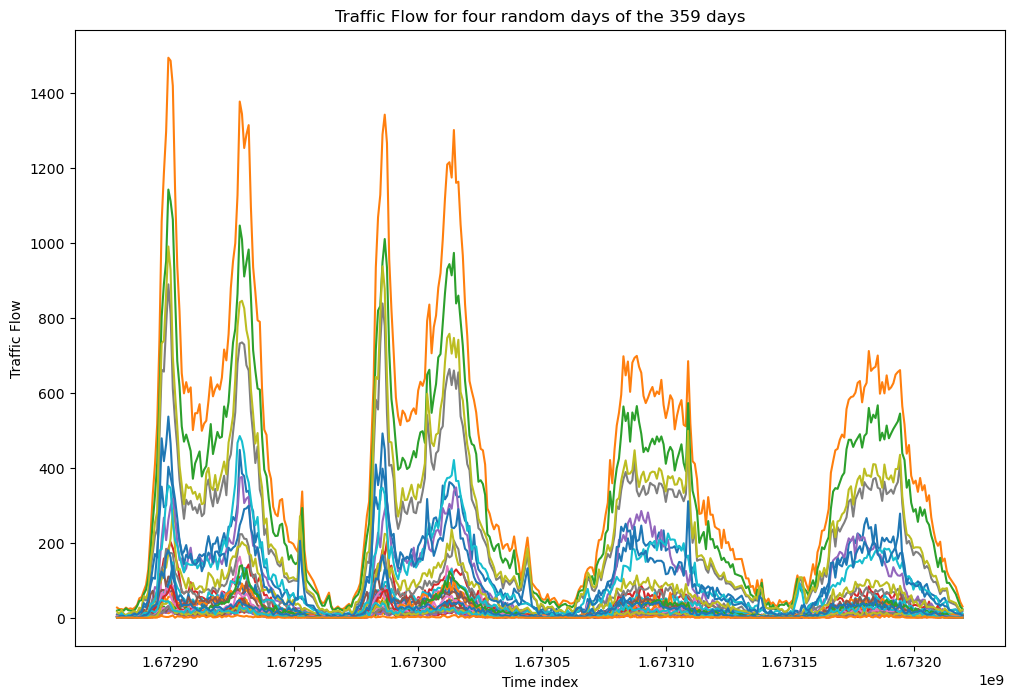

In [68]:
plt.figure(figsize=(12, 8))

for key, df in final_dataframes.items():
    plt.plot(df.index[390:770], df['traffic_flow'][390:770], label=str(key))

plt.xlabel('Time index')
plt.ylabel('Traffic Flow')
plt.title('Traffic Flow for four random days of the 359 days')
#plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

with open('one_year.pkl', 'wb') as f:
    pickle.dump(final_dataframes, f)

In [69]:
# Define the date range
start_date = pd.to_datetime('08.05.2023', format='%d.%m.%Y')
end_date = pd.to_datetime('11.05.2023', format='%d.%m.%Y')

# Filter the dataframes
for key in final_dataframes.keys():
    final_dataframes[key]['Dato'] = pd.to_datetime(final_dataframes[key]['Dato'], format='%d.%m.%Y')
    final_dataframes[key] = final_dataframes[key][(final_dataframes[key]['Dato'] >= start_date) & (final_dataframes[key]['Dato'] <= end_date)]

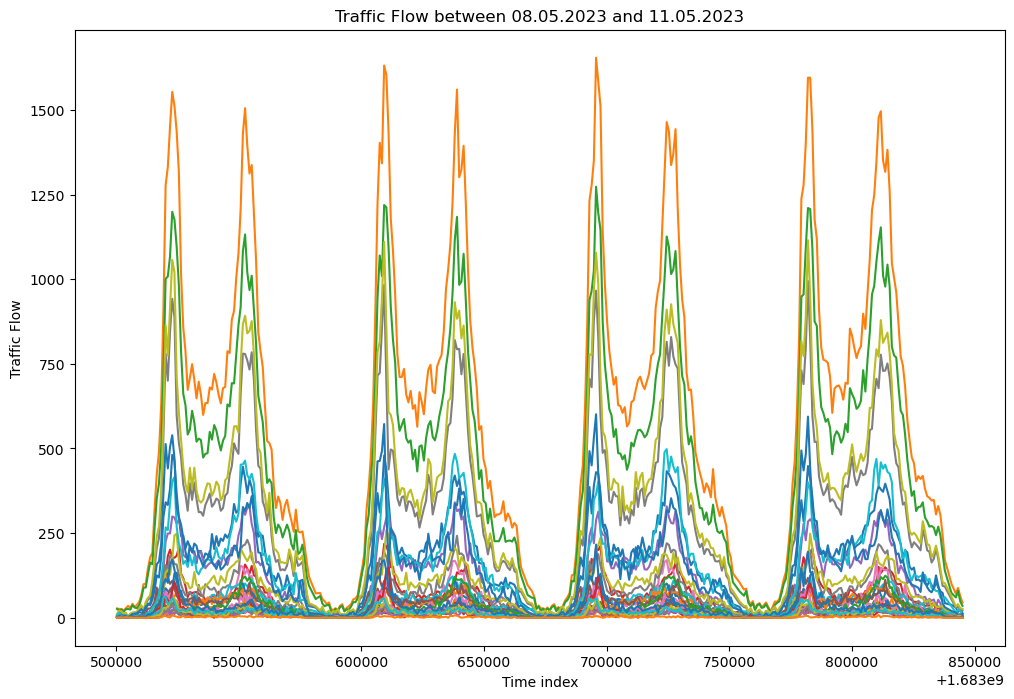

In [70]:
plt.figure(figsize=(12, 8))

for key, df in final_dataframes.items():
    plt.plot(df.index, df['traffic_flow'], label=str(key))

plt.xlabel('Time index')
plt.ylabel('Traffic Flow')
plt.title('Traffic Flow between 08.05.2023 and 11.05.2023')
#plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()

with open('four_days_data.pkl', 'wb') as f:
    pickle.dump(final_dataframes, f)